In [67]:
import skyclean

from skyclean import CMB_data

In [27]:
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
import healpy as hp
import numpy as np
import s2wav
import s2wav.filters as filters
import matplotlib.pyplot as plt
%matplotlib inline 


# Step 1: Read the Healpix map
CMB_map_path = 'data/planck_simulation/ffp10_newdust_total_030_full_map.fits'
original_healpix_map = hp.read_map(CMB_map_path)



In [72]:
CMB_data_30 = skyclean.CMB_data.CMB_Data(CMB_map_path)

hello from CMB_Data


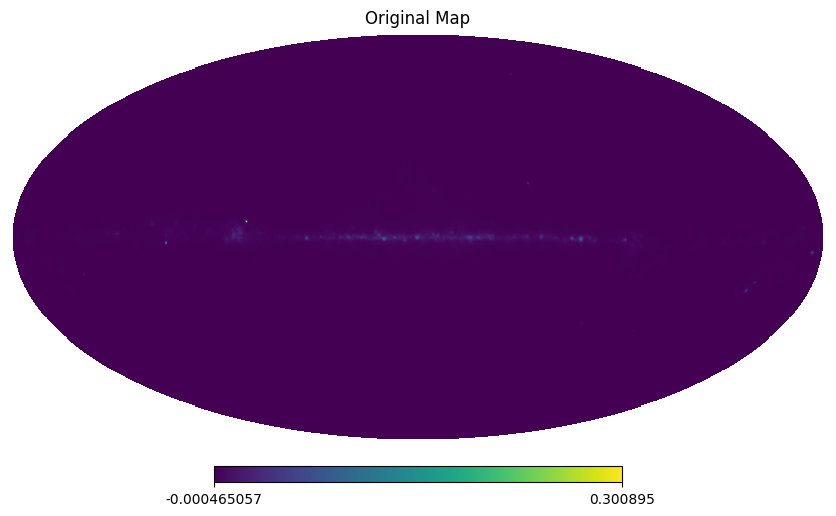

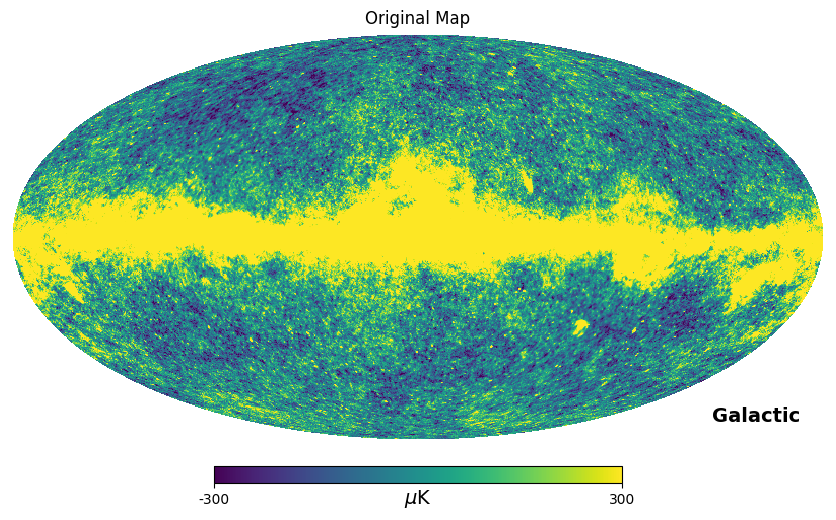

In [73]:
CMB_data_30.plot_mollview(CMB_data.original_hp_map, title='Original Map')

In [76]:
CMB_data_30.original_hp_alm = hp.map2alm(CMB_data_30.original_hp_map, lmax=CMB_data_30.lmax)

CMB_data_30.original_mw_alm = CMB_data.hp_alm_to_mw_alm(CMB_data_30.original_hp_alm, lmax=CMB_data_30.lmax)

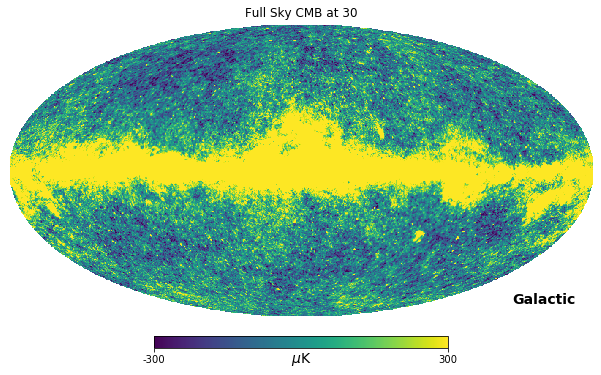

In [2]:
frequency = "30"
hp.mollview(
        original_healpix_map*1e6,
        coord=["G"],
        title="Full Sky CMB at "+frequency,
        unit=r"$\mu$K",
        min=-300, 
        max=300,
    )


In [18]:
# ##################################################################
# print("nside:", nside)
# print(f"Shape of alm: {alm.shape}")

# # the total number of spherical harmonic coefficients (alm)
# # n_coeff = （L_max+1）*（L_max+2）/2
# n_coeff = ((L_max-1)+1)*(((L_max-1))+2)//2
# n_coeff_verify = hp.Alm.getsize(L_max-1)
# print(f"Total number of coefficients (n_coeff): {n_coeff}, (n_coeff_verify): {n_coeff_verify}")

nside: 1024
Shape of alm: (2098176,)
Total number of coefficients (n_coeff): 2098176, (n_coeff_verify): 2098176


In [3]:
# Step 2: Convert Healpix map to spherical harmonic coefficients
# convention: L_max = nside * 2
nside = hp.get_nside(original_healpix_map)
L_max = nside*2  # Define maximum multipole moment / detail level
alm = hp.map2alm(original_healpix_map, lmax=L_max-1)
# lmax = L_max - 1 because python is 0-indexed

In [6]:
# Step 3: Rearrange coefficients for s2wav: from 1 dimensional to 2 dimensional
# s2fft only works with alm in 2d
alm_2d = np.zeros((L_max, 2 * L_max - 1), dtype=np.complex128)

for l in range(L_max):
    for m in range(-l, l + 1):
        index = hp.Alm.getidx(L_max - 1, l, abs(m))
        if m < 0:
            alm_2d[l, L_max + m - 1] = (-1)**m * np.conj(alm[index])
        else:
            alm_2d[l, L_max + m - 1] = alm[index]
print(f"Shape of alm_2d: {alm_2d.shape}")

Shape of alm_2d: (2048, 4095)


In [6]:
# Step 4: Apply s2fft to the 2d alm to get the map in MW sampling (2d)
# original_MW_Map = s2fft.inverse(alm_2d, L_max)
# np.save('data/original_MW_map.npy', original_MW_Map)
stored_original_MW_map = np.load('data/original_MW_map.npy')

In [5]:
# Step 5: Apply s2wav to the MW map to get the wavelet and scaling coefficients
N_directions = 1  # Number of directional wavelets
filter = filters.filters_directional_vectorised(L_max, N_directions)

wavelet_coeffs, scaling_coeffs = s2wav.analysis(stored_original_MW_map, L_max, N_directions, filters=filter,reality = False)

# Convert each element in f_wav to a numpy array and save it
for i, wav in enumerate(wavelet_coeffs):
    np_wav = np.array(wav)  # Convert JAX array to numpy array
    np.save(f"convolution/wavelet_coefficient/wav_30_{i}", np_wav)  

# Convert  f_scal to a numpy array and save it
np_scal = np.array(scaling_coeffs)  # Convert JAX array to numpy array
np.save(f"convolution/scaling_coefficient/scal_30", np_scal)  
stored_wavelet_coeffs = [np.load(f"convolution/wavelet_coefficient/wav_30_{i}.npy", allow_pickle=True) for i in range(12)]
stored_scaling_coeffs = np.load("convolution/scaling_coefficient/scal_30.npy")


In [18]:
for i in range(len(stored_wavelet_coeffs)):
    print(f"Shape of wavelet_coeffs:{i} {stored_wavelet_coeffs[i].shape}")
# print(f"Shape of wavelet_coeffs: {stored_wavelet_coeffs[1].shape}")

Shape of wavelet_coeffs:0 (1, 4, 7)
Shape of wavelet_coeffs:1 (1, 4, 7)
Shape of wavelet_coeffs:2 (1, 8, 15)
Shape of wavelet_coeffs:3 (1, 16, 31)
Shape of wavelet_coeffs:4 (1, 32, 63)
Shape of wavelet_coeffs:5 (1, 64, 127)
Shape of wavelet_coeffs:6 (1, 128, 255)
Shape of wavelet_coeffs:7 (1, 256, 511)
Shape of wavelet_coeffs:8 (1, 512, 1023)
Shape of wavelet_coeffs:9 (1, 1024, 2047)
Shape of wavelet_coeffs:10 (1, 2048, 4095)
Shape of wavelet_coeffs:11 (1, 2048, 4095)


In [47]:
# s2fft.inverse(stored_wavelet_coeffs, L_max)  # Test if the wavelet coefficients can be converted back to the MW map  

In [28]:
# Stored_original_MW_map = np.load('data/MW_Map.npy')
# # is_real = np.isreal(original_healpix_map)
# is_real = np.isreal(Stored_original_MW_map)
# print(is_real.all()) 
#  setting reality=True in the context of spherical harmonic analysis indicates that the input data is real-valued, and the function leverages the conjugate symmetry property of the harmonic coefficients to optimize storage and computation.

False


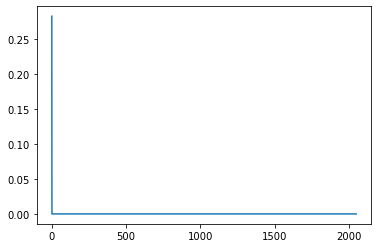

In [43]:
plt.plot(filter[1])

In [4]:
reconstructed_MW_map_raw = s2wav.synthesis(stored_wavelet_coeffs, stored_scaling_coeffs, L_max, N_directions, filters=filter, reality = False)

reconstructed_MW_map = np.array(reconstructed_MW_map_raw)
np.save(f"convolution/reconstructed_MW_map", reconstructed_MW_map)  # Save numpy array to a file
stored_reconstructed_MW_map = np.load("convolution/reconstructed_MW_map.npy")


In [10]:
print(f"Mean absolute error = {np.nanmean(np.abs(reconstructed_MW_map_raw - original_MW_Map))}")

Mean absolute error = 5.027191403597514e-15


In [8]:
print(f"Mean absolute error = {np.nanmean(np.abs(stored_reconstructed_MW_map - stored_original_MW_map))}")

Mean absolute error = 5.027191403597514e-15


In [9]:

# Step 2: Perform spherical harmonic transform using s2fft
alm_reconstructed_MW_map = s2fft.forward(stored_reconstructed_MW_map, L_max)
np.save('data/alm_reconstructed_MW_map.npy', alm_reconstructed_MW_map)
stored_alm_reconstructed_MW_map = np.load('data/alm_reconstructed_MW_map.npy')

In [10]:
# Step 3: Rearrange coefficients for healpy
n_coeff = hp.Alm.getsize(L_max-1)
reconstructed_healpix_alm = np.zeros(n_coeff, dtype=np.complex128)

for l in range(L_max):
    for m in range(-l, l + 1):
        alm_index = hp.Alm.getidx(L_max - 1, l, abs(m))
        if alm_index >= n_coeff:
            print(f"Index {alm_index} is out of bounds for alm with size {n_coeff}")
            continue
        if m < 0:
            reconstructed_healpix_alm[alm_index] = (-1) ** m * np.conj(stored_alm_reconstructed_MW_map[l, L_max + m - 1])
        else:
            reconstructed_healpix_alm[alm_index] = stored_alm_reconstructed_MW_map[l, L_max + m - 1]


In [11]:
# Now `alm` is ready to be used with healpy
nside = L_max // 2
healpix_map = hp.alm2map(reconstructed_healpix_alm, nside, verbose=False)

# Save the HEALPix map to a FITS file
output_fits_path = 'reconstructed_healpix_map.fits'
hp.write_map(output_fits_path, healpix_map, overwrite=True, dtype=np.float64)

In [12]:
new_healpix_map = hp.read_map(output_fits_path)

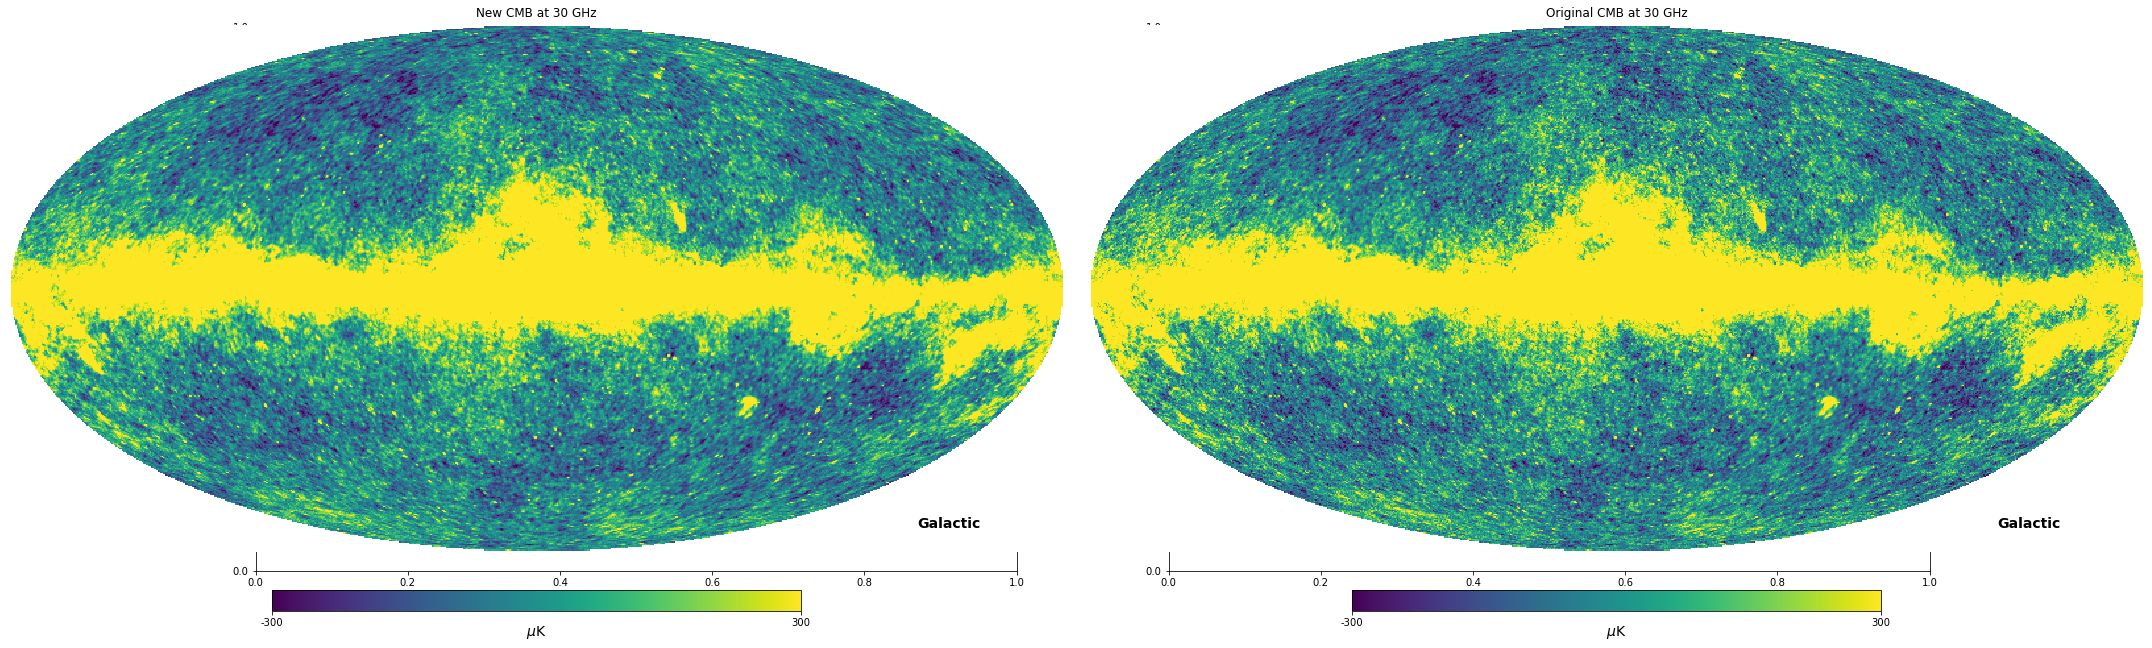

In [45]:
# Create a new figure
fig = plt.figure(figsize=(30,10))

# Plot the new HEALPix map
ax1 = fig.add_subplot(1, 2, 1)
hp.mollview(
    original_healpix_map * 1e6,
    coord=["G"],
    title="New CMB at " + frequency + " GHz",
    unit=r"$\mu$K",
    min=-300,
    max=300,
    fig=fig,
    sub=(1, 2, 1)  # Subplot configuration
)

# Plot the original HEALPix map
ax2 = fig.add_subplot(1, 2, 2)
hp.mollview(
    new_healpix_map * 1e6,
    coord=["G"],
    title="Original CMB at " + frequency + " GHz",
    unit=r"$\mu$K",
    min=-300,
    max=300,
    fig=fig,
    sub=(1, 2, 2)  # Subplot configuration
)

plt.show()

In [29]:
import numpy as np
from mayavi import mlab
import s2wav
import s2fft
from s2fft.sampling import s2_samples as samples


"""
Requirements:
    - s2fft
    - s2wav
    - numpy 
    - mayavi 
"""

def plot_sphere(f: np.ndarray, L: int, sr: float, mx: float, mn: float):

    # Define meshgrid points on spherical surface
    phis = samples.phis_equiang(L, sampling="mw")
    thetas = samples.thetas(L, sampling="mw")

    # Fix continuity at boundaries for visualisation
    thetas[0] = 0
    phis[-1] = 2 * np.pi

    # Generate angular meshgrid
    phi, theta = np.meshgrid(phis, thetas)

    # Scaling to increase/decrease magnitude of coefficient for visualisation
    temp = (f - mn) / mx
    r = sr + temp

    # Convert angular meshgrid to cartesian
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    # 3D render using mayavi package.
    mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(300, 300))
    mlab.clf()
    mlab.mesh(x, y, z, scalars=temp, colormap="viridis",vmax=1-mn/mx,vmin=0)
    mlab.show()


# if __name__ == "__main__":
#     L = 128   # Harmonic bandlimit
#     N = 1     # Azimuthal bandlimit
#     sr = 5    # How much to scale the magnitude on the sphere for visualisation.

#     # Generate the wavelet kernel in spherical harmonic space
#     # Note: this generates the directional kernel, but the actual directionality is  
#     #       introduced during the convolution. So this is just a single set of harmonic
#     #       coefficients which you can imagine being rotated during the transform.
#     J_max = s2wav.samples.j_max(L)
#     wav_lmn, scal_lm = s2wav.filters.filters_directional_vectorised(L, N)

#     # Inverse spherical harmonic transform and plot the wavelet filters on the sphere.
#     for j in range(J_max):
#         wavelet_harmonic_coeffs = wav_lmn[j]
#         wavelet_coeffs = s2fft.inverse(wavelet_harmonic_coeffs, L)

        # mx, mn = np.nanmax(np.real(wavelet_coeffs)), np.nanmin(np.real(wavelet_coeffs))
        # plot_sphere(np.real(wavelet_pixel_space), L, sr, mx, mn)

In [53]:
print("wavelet",wavelet_coeffs.shape)
print("wavelet[0]",wavelet_coeffs[0].shape)
print("wavelet[0][0]",wavelet_coeffs[0][0].shape)
print("wavelet[1]",wavelet_coeffs[1].shape)
print("wavelet[1][1]",wavelet_coeffs[1][1].shape)

wavelet (128, 255)
wavelet[0] (255,)
wavelet[0][0] ()
wavelet[1] (255,)
wavelet[1][1] ()


In [57]:
for i in range(len(filter[0])):
    print(f"Shape of filter:{i} {filter[0][i].shape}")
for i in range(len(filter[1])):
    print(f"Shape of filter:{i} {filter[1][i].shape}")

Shape of filter:0 (2048, 4095)
Shape of filter:1 (2048, 4095)
Shape of filter:2 (2048, 4095)
Shape of filter:3 (2048, 4095)
Shape of filter:4 (2048, 4095)
Shape of filter:5 (2048, 4095)
Shape of filter:6 (2048, 4095)
Shape of filter:7 (2048, 4095)
Shape of filter:8 (2048, 4095)
Shape of filter:9 (2048, 4095)
Shape of filter:10 (2048, 4095)
Shape of filter:11 (2048, 4095)
Shape of filter:0 ()
Shape of filter:1 ()
Shape of filter:2 ()
Shape of filter:3 ()
Shape of filter:4 ()
Shape of filter:5 ()
Shape of filter:6 ()
Shape of filter:7 ()
Shape of filter:8 ()
Shape of filter:9 ()
Shape of filter:10 ()
Shape of filter:11 ()
Shape of filter:12 ()
Shape of filter:13 ()
Shape of filter:14 ()
Shape of filter:15 ()
Shape of filter:16 ()
Shape of filter:17 ()
Shape of filter:18 ()
Shape of filter:19 ()
Shape of filter:20 ()
Shape of filter:21 ()
Shape of filter:22 ()
Shape of filter:23 ()
Shape of filter:24 ()
Shape of filter:25 ()
Shape of filter:26 ()
Shape of filter:27 ()
Shape of filter:28 (